In [35]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Load datasets
investors_df = pd.read_csv('cleaned_openvc.csv')
ideas_df = pd.read_csv('cleaned_ideas.csv')

# Display the first few rows of each DataFrame
print(investors_df.head())
print(ideas_df.head())


                 Investor name                        Website  \
0         3TS Capital Partners         https://3tscapital.com   
1                          3VC          https://www.three.vc/   
2            7percent Ventures         http://www.7percent.vc   
3                 10K Ventures    https://www.10kventures.co/   
4  27V (Twenty Seven Ventures)  https://twentyseven.ventures/   

                                           Global HQ  \
0  Kaisaniemenkatu 2B, 8th floor FIN-00100 Helsin...   
1                Seilergasse 9, 1010 Vienna, Austria   
2          207 Regent Street, London, United Kingdom   
3                                    Berlin, Germany   
4                                 Cayman Islands, KY   

                             Countries of investment  \
0  finland,poland,bulgaria,luxembourg,austria,tur...   
1  austria,bulgaria,croatia,czech republic,estoni...   
2  usa,albania,andorra,austria,belarus,belgium,bo...   
3  kenya,nigeria,brazil,colombia,mexico,india,in

In [36]:
# Fill NaN values with an empty string
ideas_df['idea_description'] = ideas_df['idea_description'].fillna("")

# Verify that there are no NaN values left
nan_count_after = ideas_df['idea_description'].isna().sum()
print(f"Number of NaN values after filling: {nan_count_after}")

Number of NaN values after filling: 0


In [37]:
# Create TF-IDF vectors
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform investment thesis and idea descriptions
investors_tfidf = tfidf_vectorizer.fit_transform(investors_df['Investment thesis'])
ideas_tfidf = tfidf_vectorizer.transform(ideas_df['idea_description'])

# Convert to DataFrame for easy manipulation
investors_tfidf_df = pd.DataFrame(investors_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
ideas_tfidf_df = pd.DataFrame(ideas_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Display the shapes of the resulting DataFrames
print("Investors TF-IDF DataFrame shape:", investors_tfidf_df.shape)
print("Ideas TF-IDF DataFrame shape:", ideas_tfidf_df.shape)



Investors TF-IDF DataFrame shape: (1960, 4675)
Ideas TF-IDF DataFrame shape: (23, 4675)


In [38]:
# Calculate cosine similarity between ideas and investors
similarity_matrix = cosine_similarity(ideas_tfidf, investors_tfidf)

# Get best matches for each idea
best_matches = similarity_matrix.argmax(axis=1)

# Add results to ideas DataFrame
ideas_df['best_investor'] = investors_df.iloc[best_matches]['Investor name'].values

average_cosine_score = np.mean(similarity_matrix[np.arange(len(best_matches)), best_matches])

print(f"Average Cosine Similarity Score: {average_cosine_score:.4f}")

Average Cosine Similarity Score: 0.2467


/Users/camellia/anaconda3/envs/class/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


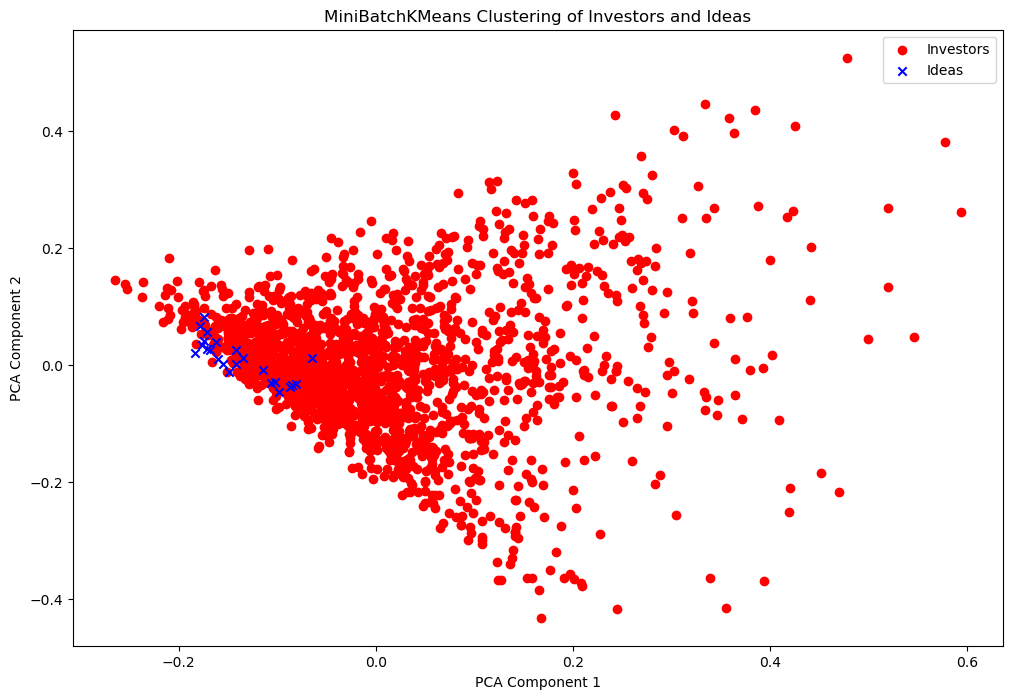


Investor Clusters:
[1323  900  607 ... 1323 1922  907]

Idea Clusters:
[1215 1323 1323 1323  243  485 1323  687  525  756  419  858  779 1859
 1123  471   74  308 1149  106 1579  931 1323]
Silhouette Score: -0.0147
Davies-Bouldin Index: 1.0020


In [39]:
combined_tfidf = np.vstack((investors_tfidf.toarray(), ideas_tfidf.toarray()))

# Initialize MiniBatchKMeans
n_clusters = len(investors_df)  # Adjust this as needed
minibatch_kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=100, random_state=42)
minibatch_kmeans.fit(combined_tfidf)

# Get cluster labels
cluster_labels = minibatch_kmeans.labels_

# Separate the clusters for investors and ideas
investor_clusters = cluster_labels[:len(investors_df)]
idea_clusters = cluster_labels[len(investors_df):]

silhouette_avg = silhouette_score(combined_tfidf, cluster_labels)
davies_bouldin = davies_bouldin_score(combined_tfidf, cluster_labels)

# 3. Visualizing Clusters with PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(combined_tfidf)

plt.figure(figsize=(12, 8))
plt.scatter(reduced_data[:len(investors_df), 0], reduced_data[:len(investors_df), 1], marker='o', color='r', label='Investors')
plt.scatter(reduced_data[len(investors_df):, 0], reduced_data[len(investors_df):, 1], marker='x', color='b', label='Ideas')
plt.title('MiniBatchKMeans Clustering of Investors and Ideas')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

# Print the clustering results
print("\nInvestor Clusters:")
print(investor_clusters)
print("\nIdea Clusters:")
print(idea_clusters)
print(f"Silhouette Score: {silhouette_avg:.4f}")
print(f"Davies-Bouldin Index: {davies_bouldin:.4f}")


In [40]:


# Ensure that the 'Investor type' has enough entries
investor_types = investors_df['Investor type'].repeat(len(ideas_df) // len(investors_df) + 1).reset_index(drop=True)

# Create a new DataFrame that contains idea descriptions and corresponding investor types
merged_df = pd.DataFrame({
    'idea_description': ideas_df['idea_description'].values[:len(investor_types)],  # Ensure this matches the length of investor_types
    'Investor type': investor_types[:len(ideas_df)]  # Slice to match the number of ideas
})

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    merged_df['idea_description'], 
    merged_df['Investor type'], 
    test_size=0.2, 
    random_state=42
)

# Hyperparameter tuning for Logistic Regression
logistic_model = make_pipeline(TfidfVectorizer(), LogisticRegression())
param_grid_logistic = {
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10],
    'logisticregression__max_iter': [100, 200, 300]
}
grid_search_logistic = GridSearchCV(logistic_model, param_grid_logistic, scoring='accuracy', cv=5)
grid_search_logistic.fit(X_train, y_train)

# Best parameters and score for Logistic Regression
print("Best parameters for Logistic Regression: ", grid_search_logistic.best_params_)
print("Best cross-validation score for Logistic Regression: ", grid_search_logistic.best_score_)

# Predictions on test set
logistic_predictions = grid_search_logistic.predict(X_test)
logistic_accuracy = accuracy_score(y_test, logistic_predictions)



/Users/camellia/anaconda3/envs/class/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best parameters for Logistic Regression:  {'logisticregression__C': 0.001, 'logisticregression__max_iter': 100}
Best cross-validation score for Logistic Regression:  0.7166666666666666


In [41]:
# Hyperparameter tuning for Random Forest
rf_model = make_pipeline(TfidfVectorizer(), RandomForestClassifier())
param_grid_rf = {
    'randomforestclassifier__n_estimators': [50, 100, 200],
    'randomforestclassifier__max_depth': [None, 10, 20, 30],
    'randomforestclassifier__min_samples_split': [2, 5, 10]
}
grid_search_rf = GridSearchCV(rf_model, param_grid_rf, scoring='accuracy', cv=5)
grid_search_rf.fit(X_train, y_train)

# Best parameters and score for Random Forest
print("Best parameters for Random Forest: ", grid_search_rf.best_params_)
print("Best cross-validation score for Random Forest: ", grid_search_rf.best_score_)

# Predictions on test set
rf_predictions = grid_search_rf.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)

/Users/camellia/anaconda3/envs/class/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best parameters for Random Forest:  {'randomforestclassifier__max_depth': None, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 50}
Best cross-validation score for Random Forest:  0.7166666666666666
